# test whether NCA can learn the square from forward training

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import diffusers
from tqdm import tqdm
from IPython.display import display, clear_output
from torchvision import transforms

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from diffusers import UNet2DModel, DDPMScheduler
from diffusers.models.embeddings import TimestepEmbedding

c:\Mine\Master\MyNca\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


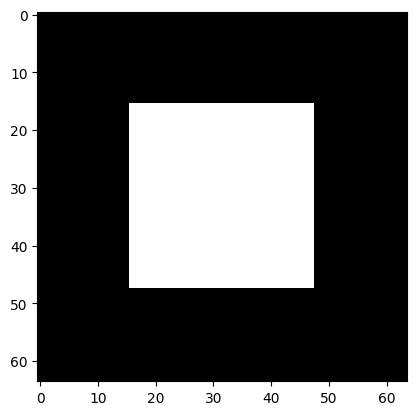

In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


image_size = 64  # 64x64 pixels
# Create a single-channel image: all zeros with a white square in the middle.
image = torch.zeros((1, 1, image_size, image_size), device=device)
image[:, :, 16:48, 16:48] = 1.0

plt.imshow(image[0, 0].cpu().numpy(), cmap='gray')

In [28]:
class NCAD(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(NCAD, self).__init__()

        self.inchannels = in_channels
        self.outchannels = out_channels
        channelWidth = 16

        
        self.conv1 = nn.Conv2d(in_channels, channelWidth, kernel_size=3, padding=1)  # 3x3 convolution
        self.conv2 = nn.Conv2d(channelWidth, channelWidth, kernel_size=1)
        self.conv3 = nn.Conv2d(channelWidth, channelWidth, kernel_size=1) # 1x1 convolution
        self.conv4 = nn.Conv2d(channelWidth, out_channels, kernel_size=1) # 1x1 convolution

    def forward(self, inp, t):
        bs, ch, height, width = inp.shape

        x = F.relu(self.conv1(inp))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        x = F.sigmoid(x)
        return x 
    
    def infer(self, x, steps, t):
        for i in range(steps):
            x = self.forward(x, t)
            # alpha_bar = self.get_alpha_bar(i, steps)  # Compute cumulative alpha_bar for step i
            # x = (alpha_bar ** 0.5) * x + ((1 - alpha_bar) ** 0.5) * self.forward(x, t)
        return x
    
timeModel = NCAD(1, 1).to(device)

TimeOp = torch.optim.Adam(timeModel.parameters(), lr=1e-4)
# singleOp = torch.optim.Adam(singleStepModel.parameters(), lr=1e-4)
# multiOp = torch.optim.Adam(multiStepModel.parameters(), lr=1e-4)

diffusionSteps = 100 # ~timesteps
scheduler = DDPMScheduler(num_train_timesteps=diffusionSteps, beta_schedule='squaredcos_cap_v2')

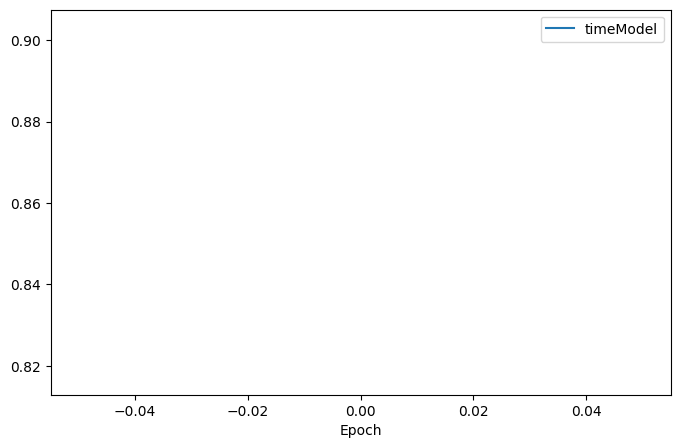

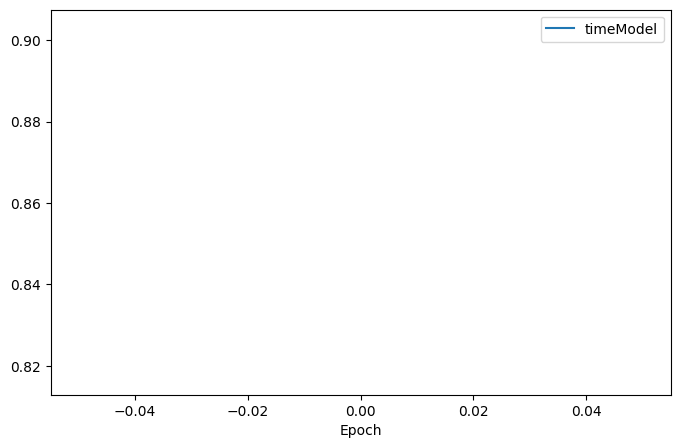

In [15]:
timeModel.train()

epochs = 1001
losses = {
    'timeModel': [],
}

fig, ax = plt.subplots(figsize=(8, 5))
display(fig)

highloss = []

for epoch in range(epochs):
    TimeOp.zero_grad()
    
    imageX = torch.rand((1, 1, 64, 64), device=device)
    #noisyImage = scheduler.add_noise(image, noise, t.long())


    for i, t in enumerate(scheduler.timesteps):
        timeTensor = torch.tensor([t]).float().to(device)
        #timeTensor = timeTensor.repeat(4)
        
        modelOut = timeModel.infer(imageX, 1, timeTensor)

        imageX = scheduler.step(modelOut, t, imageX).prev_sample

    TimeLoss = F.mse_loss(imageX, image)
    TimeLoss.backward()
    TimeOp.step()

    losses['timeModel'].append(TimeLoss.item())
    #if epoch % 100 == 0:
    clear_output(wait=True)  
    ax.clear()
    #plt.plot(losses["timeModel"][1000:], label=f'timeModel')
    plt.plot(losses["timeModel"][:], label=f'timeModel')
    plt.legend()
    plt.xlabel('Epoch')
    display(fig)
    
clear_output(wait=True)  
ax.clear()
#plt.plot(losses["timeModel"][1000:], label=f'timeModel')
plt.plot(losses["timeModel"][1000:], label=f'timeModel')
plt.legend()
plt.xlabel('Epoch')
display(fig)

<function matplotlib.pyplot.show(close=None, block=None)>

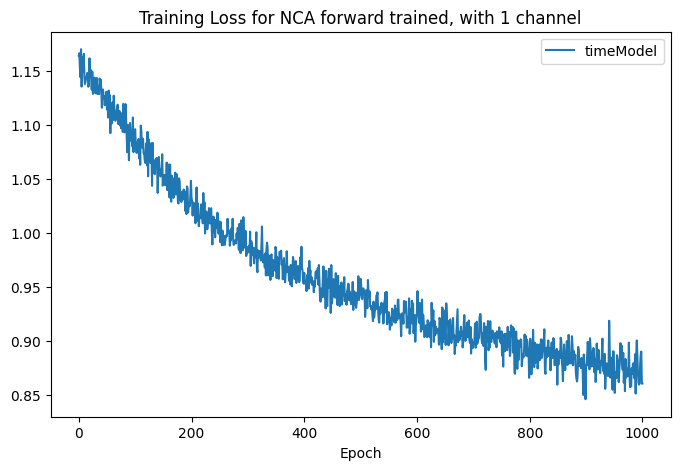

In [18]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(losses["timeModel"][:], label=f'timeModel')
plt.legend()
plt.xlabel('Epoch')
plt.title('Training Loss for NCA forward trained, with 1 channel')
plt.show

It is improving, but slow and far from 0

In [34]:
twoModel = NCAD(2, 2).to(device)

Op = torch.optim.Adam(twoModel.parameters(), lr=1e-4)
diffusionSteps = 100 # ~timesteps
scheduler = DDPMScheduler(num_train_timesteps=diffusionSteps, beta_schedule='squaredcos_cap_v2')

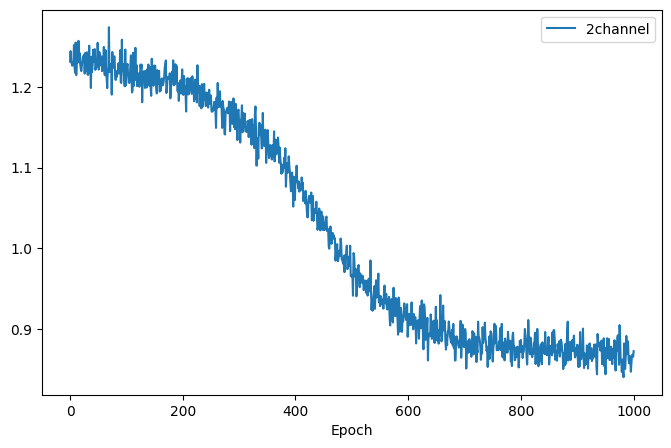

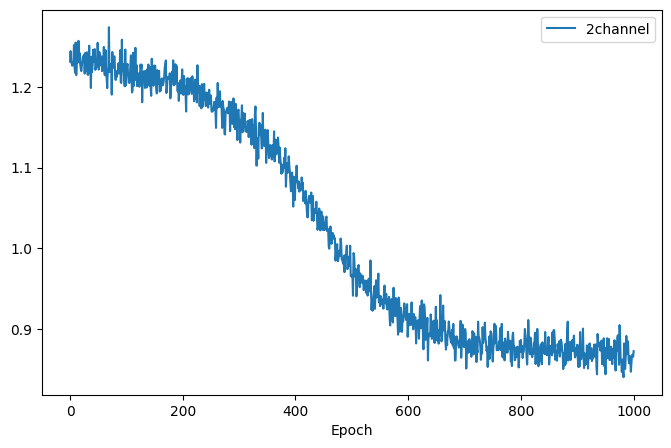

In [35]:
def trainModelForward(model, channels, lossDict, id, ncaSteps, epochs, optimizer, target):
    model.train()

    fig, ax = plt.subplots(figsize=(8, 5))
    display(fig)
    lossDict[id] = []

    for epoch in range(epochs):
        optimizer.zero_grad()
    
        imageX = torch.zeros((1, channels, 64, 64), device=device)
        noise = torch.rand((64, 64), device=device)
        imageX[0, 0] = noise

        
        for i, t in enumerate(scheduler.timesteps):
            timeTensor = torch.tensor([t]).float().to(device)            
            modelOut = model.infer(imageX, ncaSteps, timeTensor)
            imageX = scheduler.step(modelOut, t, imageX).prev_sample

        Loss = F.mse_loss(imageX[0, 0], image[0, 0])
        Loss.backward()
        Op.step()

        lossDict[id].append(Loss.item())
        #if epoch % 100 == 0:
        clear_output(wait=True)  
        ax.clear()
        #plt.plot(losses["timeModel"][1000:], label=f'timeModel')
        plt.plot(lossDict[id][:], label=id)
        plt.legend()
        plt.xlabel('Epoch')
        display(fig)

    return model, losses

twoModel, losses = trainModelForward(twoModel, 2, losses, '2channel', 1, 1001, Op, image)

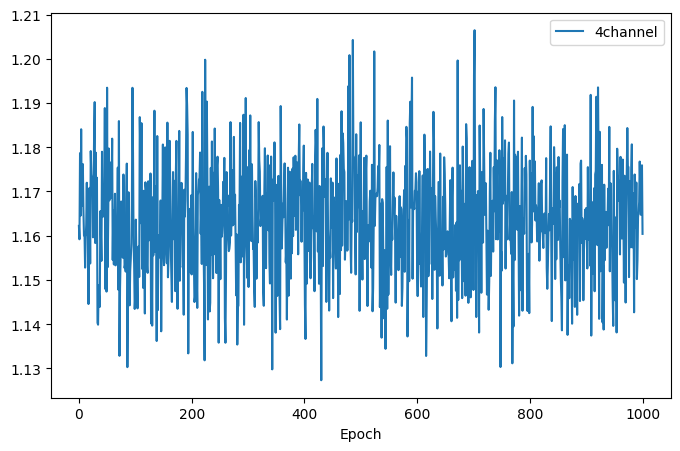

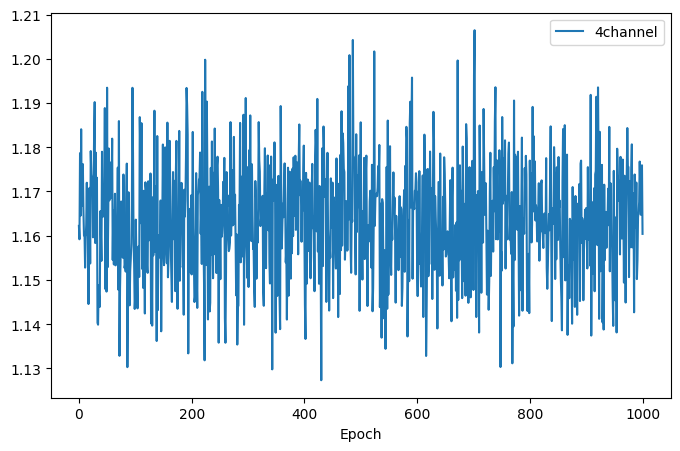

In [39]:
# fourModel = NCAD(4, 4).to(device)

# Op = torch.optim.Adam(twoModel.parameters(), lr=1e-4)
# diffusionSteps = 100 # ~timesteps
# scheduler = DDPMScheduler(num_train_timesteps=diffusionSteps, beta_schedule='squaredcos_cap_v2')

fourModel, losses = trainModelForward(fourModel, 4, losses, '4channel', 1, 1001, Op, image)

In [ ]:
timeModel.train()

epochs = 1001
losses = {
    'timeModel': [],
}

fig, ax = plt.subplots(figsize=(8, 5))
display(fig)

highloss = []

for epoch in range(epochs):
    TimeOp.zero_grad()
    
    imageX = torch.rand((1, 1, 64, 64), device=device)
    #noisyImage = scheduler.add_noise(image, noise, t.long())


    for i, t in enumerate(scheduler.timesteps):
        timeTensor = torch.tensor([t]).float().to(device)
        #timeTensor = timeTensor.repeat(4)
        
        modelOut = timeModel.infer(imageX, 1, timeTensor)

        imageX = scheduler.step(modelOut, t, imageX).prev_sample

    TimeLoss = F.mse_loss(imageX, image)
    TimeLoss.backward()
    TimeOp.step()

    losses['timeModel'].append(TimeLoss.item())
    #if epoch % 100 == 0:
    clear_output(wait=True)  
    ax.clear()
    #plt.plot(losses["timeModel"][1000:], label=f'timeModel')
    plt.plot(losses["timeModel"][:], label=f'timeModel')
    plt.legend()
    plt.xlabel('Epoch')
    display(fig)
    
clear_output(wait=True)  
ax.clear()
#plt.plot(losses["timeModel"][1000:], label=f'timeModel')
plt.plot(losses["timeModel"][1000:], label=f'timeModel')
plt.legend()
plt.xlabel('Epoch')
display(fig)

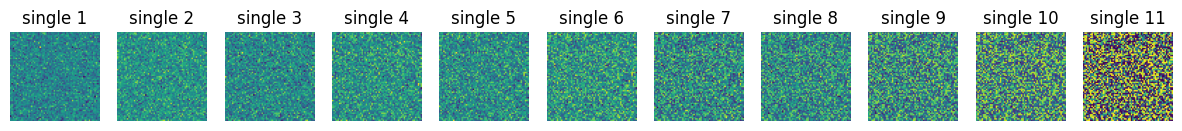

In [17]:
# Inference of trained models 

timeModel.eval()

inferenceSteps = 100
scheduler.set_timesteps(inferenceSteps)

with torch.no_grad():
    singleX = torch.randn_like(image).to(device)
    intermediateImages = {
        'single': [],
        'multi': [],
    }

    for i, t in enumerate(scheduler.timesteps):
        timeTensor = torch.tensor([t]).float().to(device)
        singleOut = timeModel.infer(singleX, 1, timeTensor)

        singleX = scheduler.step(singleOut, t, singleX).prev_sample

        if i % 10  == 0:
            intermediateImages['single'].append(singleX.cpu().numpy())
    
    #Might be a duplicate from last step
    intermediateImages['single'].append(singleX.cpu().numpy())

numColumns = len(intermediateImages['single'])
fig, axs = plt.subplots(1, numColumns, figsize=(15, 3))

# Plot images
for row, key in enumerate(['single']):
    for col, img in enumerate(intermediateImages[key]):
        axs[ col].imshow(img[0,0])
        axs[ col].axis('off')  
        axs[ col].set_title(f"{key} {col+1}")  


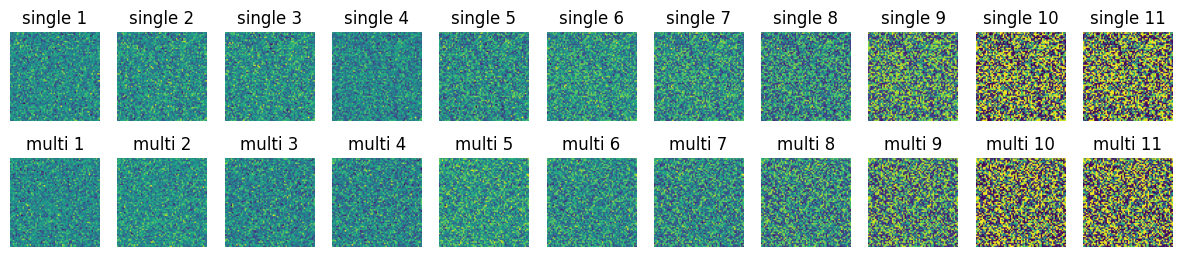

In [8]:
# Inference of trained models 

singleStepModel.eval()
multiStepModel.eval()

inferenceSteps = 20
scheduler.set_timesteps(inferenceSteps)

with torch.no_grad():
    singleX = torch.randn_like(image).to(device)
    multiX = singleX.clone()
    intermediateImages = {
        'single': [],
        'multi': [],
    }

    for i, t in enumerate(scheduler.timesteps):
        timeTensor = torch.tensor([t]).float().to(device)
        singleOut = singleStepModel.infer(singleX, 1, timeTensor)
        multiOut = multiStepModel.infer(multiX, 20, timeTensor)

        singleX = scheduler.step(singleOut, t, singleX).prev_sample
        multiX = scheduler.step(multiOut, t, multiX).prev_sample

        if i % 2:
            intermediateImages['single'].append(singleX.cpu().numpy())
            intermediateImages['multi'].append(multiX.cpu().numpy())
    
    #Might be a duplicate from last step
    intermediateImages['single'].append(singleX.cpu().numpy())
    intermediateImages['multi'].append(multiX.cpu().numpy())

numColumns = len(intermediateImages['single'])
fig, axs = plt.subplots(2, numColumns, figsize=(15, 3))

# Plot images
for row, key in enumerate(['single', 'multi']):
    for col, img in enumerate(intermediateImages[key]):
        axs[row, col].imshow(img[0,0])
        axs[row, col].axis('off')  
        axs[row, col].set_title(f"{key} {col+1}")  
